# Capstone 3 Modeling

**The Data Science Method**  

1.   Problem Identification 

2.   Data Wrangling 
  * Data Collection 
   * Data Organization
  * Data Definition 
  * Data Cleaning
 
3.   Exploratory Data Analysis
 * Build data profile tables and plots
        - Outliers & Anomalies
 * Explore data relationships
 * Identification and creation of features

4.   Pre-processing and Training Data Development
  * Create dummy or indicator features for categorical variables
  * Standardize the magnitude of numeric features
  * Split into testing and training datasets
  * Apply scaler to the testing set
  
5.   **Modeling**
  * Fit Models with Training Data Set
  * Review Model Outcomes — Iterate over additional models as needed.
  * Identify the Final Model

6.   Documentation
  * Review the Results
  * Present and share your findings - storytelling
  * Finalize Code 
  * Finalize Documentation

## Data Collection

In [1]:
#load python packages
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x) #get rid of scientific notations
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import time
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.api import VAR
from IPython.display import Image
%matplotlib inline

In [2]:
# switch to processed data folder
os.chdir('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Three\\data\\processed\\')
os.getcwd()

'C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Three\\data\\processed'

In [3]:
# load the combined csv file
df = pd.read_csv('combined.csv')
df.head()

,Zipcode,County,Date,Value,Bedrooms
0,94109,San Francisco County,1996-01-31,263374,1
1,90250,Los Angeles County,1996-01-31,184141,1
2,90046,Los Angeles County,1996-01-31,119677,1
3,94501,Alameda County,1996-01-31,119742,1
4,94110,San Francisco County,1996-01-31,221428,1


In [4]:
# check info
df['Date'] = pd.to_datetime(df.Date)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 563732 entries, 0 to 563731
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   Zipcode   563732 non-null  int64         
 1   County    563732 non-null  object        
 2   Date      563732 non-null  datetime64[ns]
 3   Value     563732 non-null  int64         
 4   Bedrooms  563732 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 21.5+ MB


In [5]:
# break the df into 4 of them indicating the number of bedrooms and drop the county and bedrooms column
df1 = df.loc[df['Bedrooms']==1]
df1 = df1.sort_values(['Date','Zipcode'])
df2 = df.loc[df['Bedrooms']==2]
df2 = df2.sort_values(['Date','Zipcode'])
df3 = df.loc[df['Bedrooms']==3]
df3 = df3.sort_values(['Date','Zipcode'])
df4 = df.loc[df['Bedrooms']==4]
df4 = df4.sort_values(['Date','Zipcode'])
df1.tail() # previous when the date wasn't in date time and sort by date will see 2019 in tail()

,Zipcode,County,Date,Value,Bedrooms
140604,95821,Sacramento County,2020-05-31,159237,1
140568,95822,Sacramento County,2020-05-31,301542,1
140598,95825,Sacramento County,2020-05-31,169082,1
140808,96150,El Dorado County,2020-05-31,321712,1
140837,96161,Nevada County,2020-05-31,346110,1


# Preprocess for VARMAX model
need the values to be differenced first then cube root it

In [6]:
# define a function that takes in the df, and the number of diff value and root value (needs to be odd numbers)
def data_trans(df, val_name):
    temp = pd.DataFrame({})
    # add Zipcode as columns and its values to temp
    for zipcode in list(df.Zipcode.unique()):
        temp[zipcode] = list(df[df['Zipcode']==zipcode].Value)
    # difference the data
    temp = temp.diff().dropna()
    # get make the dataset cube root
    for zipcode in list(df.Zipcode.unique()):
        temp[zipcode] = temp[zipcode].apply(lambda x: (x**(1/5)))
    # add Date column to so we can melt it, starting date is 1996-2-29 periods=293 since it's differenced and lost 1 month
    temp['Date'] = pd.date_range('1996-02-29', periods=292, freq='M')
    # melt and sort
    temp_melt = pd.melt(temp, id_vars=['Date'], var_name='Zipcode', value_name=val_name)
    temp_sort = temp_melt.sort_values(['Date','Zipcode'])
    # have the Values in float since it has imaginary number
    temp_sort[val_name] = temp_sort[val_name].astype('float64')
    # set the Date as index
    temp_sort.set_index('Date', inplace=True)
    return temp_sort

In [7]:
df1t = data_trans(df1, 'OneBR')
df2t = data_trans(df2, 'TwoBR')
df3t = data_trans(df3, 'ThreeBR')
df4t = data_trans(df4, 'FourBR')
dft = df1t
dft['TwoBR'] = df2t.TwoBR
dft['ThreeBR'] = df3t.ThreeBR
dft['FourBR'] = df4t.FourBR
dft

,Zipcode,OneBR,TwoBR,ThreeBR,FourBR
Date,,,,,
1996-02-29,90004,3.1354,2.7693,3.4461,3.5714
1996-02-29,90007,2.4601,2.9041,2.4769,2.5660
1996-02-29,90012,4.6568,4.4153,3.0385,2.5317
1996-02-29,90016,2.8302,2.4271,2.3639,2.8742
1996-02-29,90018,3.1029,2.1482,2.3793,2.9118
...,...,...,...,...,...
2020-05-31,95821,3.7342,2.2526,2.8560,3.2543
2020-05-31,95822,3.3227,3.1518,3.3145,2.9247
2020-05-31,95825,3.2103,1.5522,2.8972,3.6416


# Modeling

In [8]:
# set the endog (training data)
endog = dft.loc['1996-2-29':'2015-05-31']
endog.tail()

,Zipcode,OneBR,TwoBR,ThreeBR,FourBR
Date,,,,,
2015-05-31,95821,3.3501,4.1480,4.5970,4.8473
2015-05-31,95822,3.9195,4.9346,4.6042,4.6891
2015-05-31,95825,2.5508,2.6944,4.5028,4.8268
2015-05-31,96150,3.0407,2.0824,3.5669,3.4853
2015-05-31,96161,4.5028,1.0000,3.3195,3.9643


In [9]:
# iterate zipcode to subset and model/fit/predict
# create dfs to store values
pred_df1 = pd.DataFrame({'Date':pd.date_range('2015-06-30', periods=60, freq='M')})
pred_df2 = pred_df1
pred_df3 = pred_df1
pred_df4 = pred_df1
# iterate thru zipcode and get the values stored; order=(1,0) trend='n' since the data is stationary
start = time.time()
for zipcode in list(dft.Zipcode.unique()):
    # get the endog by subsetting the dft with specific zipcode and collumns other thatn zipcode
    endog_sub = endog[endog['Zipcode']==zipcode][[i for i in list(dft.columns)][1:]]
    endog_sub.index.freq = 'M' #set the datetime frequency
    # train/fit the model
    model = sm.tsa.VARMAX(endog_sub, order=(1,0), trend='n')
    result = model.fit(maxiter=1000, disp=False)
    # forecast
    pred = result.predict(start='2015-06-30', end='2020-05-31')
    # append data to dataframes
    pred_df1[zipcode] = list(pred.OneBR)
    pred_df2[zipcode] = list(pred.TwoBR)
    pred_df3[zipcode] = list(pred.ThreeBR)
    pred_df4[zipcode] = list(pred.FourBR)
# stop timer
end = time.time()
fit_time = (end-start)
#check the fit time in min
int(fit_time/60)

16

# Transform predictions back to original format

In [10]:
# create a function to inverse the diff by having the first value
def diff_inv(series_diff, first_value):
    series = np.r_[first_value, series_diff].cumsum().astype('float64')
    return series

In [11]:
# test the function above
x = pd.DataFrame({'test':[3,7,2,6,8,0,5,0,4,9,5]})
x['diff'] = x.diff()
x_diff = x['diff'].dropna() # x_diff is a dataframe with single column
display(diff_inv(x_diff, 3))

array([3., 7., 2., 6., 8., 0., 5., 0., 4., 9., 5.])

In [12]:
# define a function that will revert back the prediction values
def pred_trans(pred_df, original_df, val_name):
    temp = pd.DataFrame({}) #create dfs to store values
    restored = pd.DataFrame({'Date':pd.date_range('2015-05-31', periods=61, freq='M')})
    for col in list(pred_df.columns)[1:]:
        # let's inverse the cube root
        temp[col] = list(pred_df[col].apply(lambda x: (x**5)))
    for col in list(pred_df.columns)[1:]:
        # inverse the diff()
        original_df_sub = original_df[original_df['Zipcode']==col]
        first_value = original_df_sub.iloc[-61].Value
        restored[col] = diff_inv(temp[col], first_value)
    # melt
    temp_melt = pd.melt(restored, id_vars=['Date'], var_name='Zipcode', value_name=val_name)
    # make sure date is datetime
    temp_melt['Date'] = pd.to_datetime(temp_melt.Date)
    # sort
    temp_sort = temp_melt.sort_values(['Date','Zipcode'])
    # have the Values in int so it's easier to read and compared to original values
    temp_sort[val_name] = temp_sort[val_name].astype('int64')
    return temp_sort

In [13]:
# transform and compile the prediction
pred_dft = pred_trans(pred_df1, df1, 'OneBR')
pred_dft2 = pred_trans(pred_df2, df2, 'TwoBR')
pred_dft3 = pred_trans(pred_df3, df3, 'ThreeBR')
pred_dft4 = pred_trans(pred_df4, df4, 'FourBR')
pred_dft['TwoBR'] = pred_dft2.TwoBR
pred_dft['ThreeBR'] = pred_dft3.ThreeBR
pred_dft['FourBR'] = pred_dft4.FourBR
# save the restored prediciton to csv file
pred_dft.to_csv('varmax_pred5D5R.csv', index=False)
pred_dft.head()

,Date,Zipcode,OneBR,TwoBR,ThreeBR,FourBR
0,2015-05-31,90004,503131,657457,676793,989347
61,2015-05-31,90007,411202,411318,477961,537158
122,2015-05-31,90012,440790,463270,565995,586078
183,2015-05-31,90016,350886,452026,528033,613194
244,2015-05-31,90018,392959,442982,473918,549588


In [14]:
# load the transformed data
pred_dft = pd.read_csv('varmax_pred5D5R.csv')
pred_dft['Date'] = pd.to_datetime(pred_dft.Date) # make sure Date column is datetime!
pred_dft.head()

,Date,Zipcode,OneBR,TwoBR,ThreeBR,FourBR
0,2015-05-31,90004,503131,657457,676793,989347
1,2015-05-31,90007,411202,411318,477961,537158
2,2015-05-31,90012,440790,463270,565995,586078
3,2015-05-31,90016,350886,452026,528033,613194
4,2015-05-31,90018,392959,442982,473918,549588


In [15]:
# let's try plotting the mean/medians of test and pred, we will need to define functions
# define a function that takes in the prediction dataframe and return the medians
def median_calc(data, nobs, val_column):
    p_medians = []
    for i in range(nobs): 
        median = data.sort_values(['Date',val_column]).iloc[240+481*i][val_column]
        p_medians.append(int(median))
    return p_medians
# define a function that takes in the prediction dataframe and return the means
def mean_calc(data, val_column):
    p_means = []
    for i in list(data.Date.unique()): # get the dates to iterate
        mean = data[data['Date']==i][val_column].mean() # get the mean
        p_means.append(int(mean))
    return p_means

In [16]:
# load the z_avg csv which has zillow's averages
z_avg = pd.read_csv('z_avg.csv')
z_avg['Date'] = pd.to_datetime(z_avg.Date)
z_avg.head()

,Date,median1,median2,median3,median4,mean1,mean2,mean3,mean4
0,1996-01-31,126629,151063,195056,236146,139968,166773,216547,271840
1,1996-02-29,126756,150874,195081,237121,139737,166504,216264,271489
2,1996-03-31,126961,150725,194693,237551,139610,166329,216122,271286
3,1996-04-30,126710,150730,193976,236331,139321,165978,215829,270924
4,1996-05-31,126223,150643,193362,237570,139107,165726,215630,270713


In [17]:
# let's compiles the means and medians to form a new dataframe and plot on seaborn
z_df = pd.DataFrame({'Date':pd.date_range('1996-01-31', periods=293, freq='M')})
z_df['z_median_OneBR'] = z_avg.median1
z_df['z_median_TwoBR'] = z_avg.median2
z_df['z_median_ThreeBR'] = z_avg.median3
z_df['z_median_FourBR'] = z_avg.median4
z_df['z_mean_OneBR'] = z_avg.mean1
z_df['z_mean_TwoBR'] = z_avg.mean2
z_df['z_mean_ThreeBR'] = z_avg.mean3
z_df['z_mean_FourBR'] = z_avg.mean4
# do the same for prediction
pred_date_num = pred_dft.Date.nunique()
p_df = pd.DataFrame({'Date':pd.date_range('2015-05-31', periods=pred_date_num, freq='M')})
p_df['p_median_OneBR'] = median_calc(pred_dft, pred_date_num, 'OneBR')
p_df['p_median_TwoBR'] = median_calc(pred_dft, pred_date_num, 'TwoBR')
p_df['p_median_ThreeBR'] = median_calc(pred_dft, pred_date_num, 'ThreeBR')
p_df['p_median_FourBR'] = median_calc(pred_dft, pred_date_num, 'FourBR')
p_df['p_mean_OneBR'] = mean_calc(pred_dft, 'OneBR')
p_df['p_mean_TwoBR'] = mean_calc(pred_dft, 'TwoBR')
p_df['p_mean_ThreeBR'] = mean_calc(pred_dft, 'ThreeBR')
p_df['p_mean_FourBR'] = mean_calc(pred_dft, 'FourBR')

In [18]:
# melt and we need the following columns for seaborn: Date, measure_type, Value, Bedrooms, Source
z_melt = pd.melt(z_df, ['Date'])
p_melt = pd.melt(p_df, ['Date'])
sea_df = pd.concat([z_melt, p_melt])
sea_df.head()

,Date,variable,value
0,1996-01-31,z_median_OneBR,126629
1,1996-02-29,z_median_OneBR,126756
2,1996-03-31,z_median_OneBR,126961
3,1996-04-30,z_median_OneBR,126710
4,1996-05-31,z_median_OneBR,126223


In [19]:
# create a list to add the measure type, bedrooms, and sources
measure_list=[]
for i in sea_df.variable:
    if 'median' in i:
        measure_list.append('median')
    else:
        measure_list.append('mean')
# do the same for number of bedrooms
BR_list=[]
for i in sea_df.variable:
    if 'One' in i:
        BR_list.append(1)
    if 'Two' in i:
        BR_list.append(2)
    if 'Three' in i:
        BR_list.append(3)
    if 'Four' in i:
        BR_list.append(4)
# source        
source_list=[]
for i in sea_df.variable:
    if 'z_m' in i:
        source_list.append('zillow')
    else:
        source_list.append('varmax')
# add the columns to sea_df
sea_df['measure_type'] = measure_list
sea_df['Bedrooms'] = BR_list
sea_df['Source'] = source_list
display(sea_df.head(3))
sea_df.tail(3)

,Date,variable,value,measure_type,Bedrooms,Source
0,1996-01-31,z_median_OneBR,126629,median,1,zillow
1,1996-02-29,z_median_OneBR,126756,median,1,zillow
2,1996-03-31,z_median_OneBR,126961,median,1,zillow


,Date,variable,value,measure_type,Bedrooms,Source
485,2020-03-31,p_mean_FourBR,1102111,mean,4,varmax
486,2020-04-30,p_mean_FourBR,1103995,mean,4,varmax
487,2020-05-31,p_mean_FourBR,1105843,mean,4,varmax


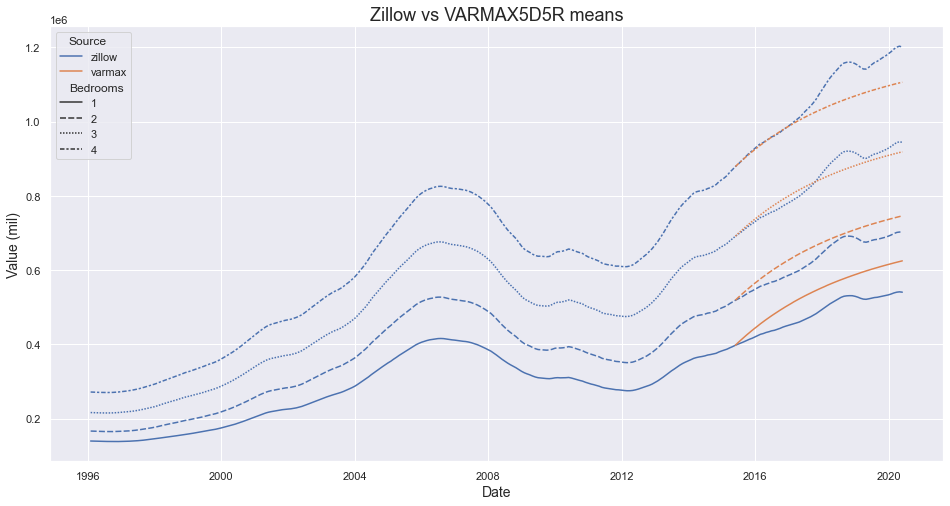

In [20]:
# plot the means using seaborn
sns.set_theme(style="darkgrid")
sea_mean = sea_df[sea_df['measure_type']=='mean'] #subset with only the means
fig, ax = plt.subplots(figsize=(16, 8)) # set the figure size and ax to graph on
sea = sns.lineplot(data=sea_mean, x="Date", y="value", hue="Source", style="Bedrooms", ax=ax)
sea.axes.set_title("Zillow vs VARMAX5D5R means",fontsize=18)
sea.set_xlabel("Date",fontsize=14)
sea.set_ylabel("Value (mil)",fontsize=14)
plt.savefig('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Three\\figures\\Zillow_vs_VARMAX5D5R_means.png')

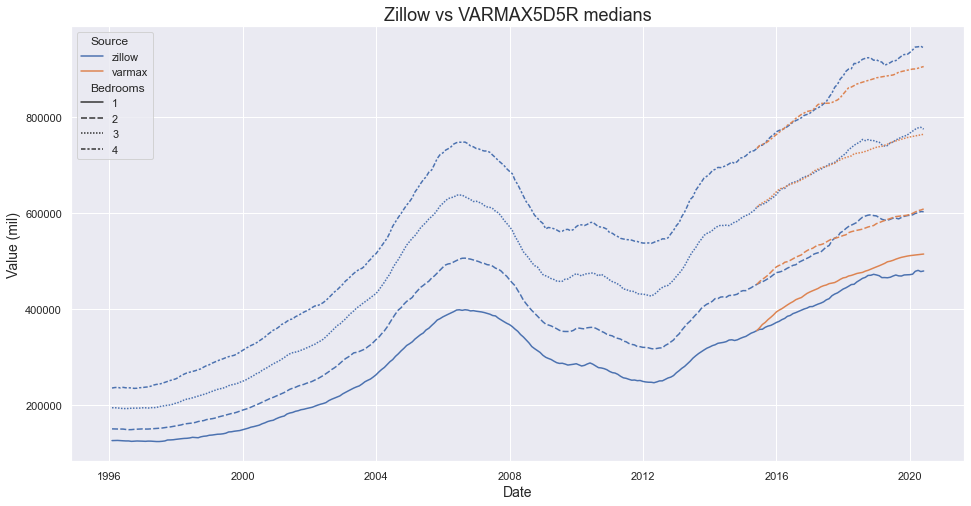

In [21]:
# plot the median using seaborn
sns.set_theme(style="darkgrid")
sea_mean = sea_df[sea_df['measure_type']=='median'] #subset with only the means
fig, ax = plt.subplots(figsize=(16, 8)) # set the figure size and ax to graph on
sea = sns.lineplot(data=sea_mean, x="Date", y="value", hue="Source", style="Bedrooms", ax=ax)
sea.axes.set_title("Zillow vs VARMAX5D5R medians",fontsize=18)
sea.set_xlabel("Date",fontsize=14)
sea.set_ylabel("Value (mil)",fontsize=14)
plt.savefig('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Three\\figures\\Zillow_vs_VARMAX5D5R_medians.png')

The predictions for the first 2 years seems okay, we shall compare the model scores based on each 12 months of data.

In [22]:
pred_dft.head(2)

,Date,Zipcode,OneBR,TwoBR,ThreeBR,FourBR
0,2015-05-31,90004,503131,657457,676793,989347
1,2015-05-31,90007,411202,411318,477961,537158


In [23]:
# let's make a test dataframe
def test_data_form(df, BR_num, val_name):
    temp=pd.DataFrame({})
    for zipcode in pred_dft.Zipcode.unique():
        df_sub = df[(df['Zipcode']==zipcode) & (df['Bedrooms']==BR_num)] #subset by zipcode and num of bedroom
        df_sub = df_sub[df_sub['Date']>='2015-05-31'] # get corresponding date range
        temp['Date'] = pd.date_range('2015-05-31', periods=len(df_sub), freq='M')
        temp[zipcode]=list(df_sub.Value)
    # melt
    temp_melt = pd.melt(temp, id_vars=['Date'], var_name='Zipcode', value_name=val_name)
    # make sure date is datetime
    temp_melt['Date'] = pd.to_datetime(temp_melt.Date)
    # sort
    temp_sort = temp_melt.sort_values(['Date','Zipcode'])
    # have the Values in int so it's easier to read and compared to original values
    temp_sort[val_name] = temp_sort[val_name].astype('int64')
    return temp_sort

In [24]:
# make a compiled dataframe
test = test_data_form(df,1, 'OneBR')
test2 = test_data_form(df,2, 'TwoBR')
test3 = test_data_form(df,3, 'ThreeBR')
test4 = test_data_form(df,4, 'FourBR')
test['TwoBR'] = test2.TwoBR
test['ThreeBR'] = test3.ThreeBR
test['FourBR'] = test4.FourBR
test.head()

,Date,Zipcode,OneBR,TwoBR,ThreeBR,FourBR
0,2015-05-31,90004,503131,657457,676793,989347
61,2015-05-31,90007,411202,411318,477961,537158
122,2015-05-31,90012,440790,463270,565995,586078
183,2015-05-31,90016,350886,452026,528033,613194
244,2015-05-31,90018,392959,442982,473918,549588


In [25]:
pred_dft.set_index('Date',inplace=True)
test.set_index('Date',inplace=True)

In [26]:
# calculate the MAEs and add to lists
model_list=[]
MAE_list=[]
for i in range(0,5):
    test_sub = test.iloc[i*481:(1+i)*481*12]
    pred_sub = pred_dft.iloc[i*481:(1+i)*481*12]
    model_list.append('VARMAX5D5R')
    MAE = mean_absolute_error(test_sub, pred_sub)
    MAE_list.append(MAE)
for i in range(1,5):
    test_sub = test.iloc[:, i]
    pred_sub = pred_dft.iloc[:, i]
    model_list.append('VARMAX5D5R')
    MAE = mean_absolute_error(test_sub, pred_sub)
    MAE_list.append(MAE)
# make a dataframe and save the info
model_score = pd.DataFrame({
    'Model': model_list,
    'Calc_by': ['15to16', '16to17', '17to18','18to19','19to20', '1BR','2BR','3BR','4BR'],
    'MAE':MAE_list
})
model_score.to_csv('VARMAX5D5R_score.csv')
model_score

,Model,Calc_by,MAE
0,VARMAX5D5R,15to16,15202.5976
1,VARMAX5D5R,16to17,30057.4639
2,VARMAX5D5R,17to18,41494.7123
3,VARMAX5D5R,18to19,52127.5752
4,VARMAX5D5R,19to20,61757.5886
5,VARMAX5D5R,1BR,78704.7388
6,VARMAX5D5R,2BR,63620.9024
7,VARMAX5D5R,3BR,65178.7729
8,VARMAX5D5R,4BR,85972.6994
